In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from thesis.io import gyre, fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate

import jax
import jax.numpy as jnp
from jax import random
jax.config.update("jax_enable_x64", True)

import jaxopt
from corner import corner

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
gong = fgong.load_fgong(filename)
gong

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [3]:
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [4]:
data = gong.merge(pulse, combine_attrs="drop_conflicts")
data

<xarray.Dataset>
Dimensions:       (x: 1046, n_pg: 36, l: 3)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
  * n_pg          (n_pg) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * l             (l) int64 0 1 2
Data variables: (12/44)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    omega         (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As            (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2           (x, n_pg, l) float64 125.5 nan 125.5 ... 5.896e+03 nan nan
    c_1           (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
    xi_r          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
Attributes: (12/17)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08
    freq_units:      UHZ
    label:

In [5]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


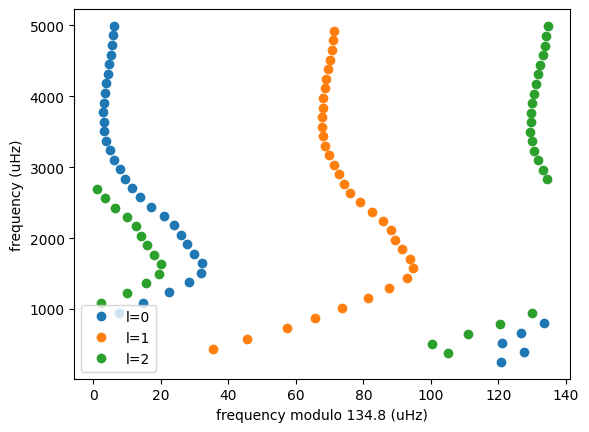

In [6]:
fig = plt.figure()

freq_mod = data.freq.real%nu0
for j in data.l:
    plt.plot(freq_mod.sel(l=j), data.freq.real.sel(l=j), 'o', color=f'C{j:d}', label=f'l={j:d}')
#     plt.plot(freq_mod.sel(l=j)-nu0, ds.freq.real.sel(l=j), 'o', color=f'C{j:d}')

plt.xlabel(f'frequency modulo {nu0:.1f} (uHz)')
plt.ylabel('frequency (uHz)')
plt.legend();

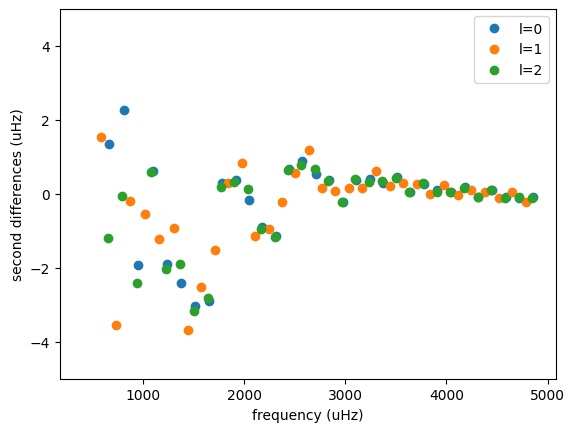

In [7]:
plt.figure()

d2nu = data.freq.real[:-2].values - 2 * data.freq.real[1:-1].values + data.freq.real[2:].values

for j in range(3):
    plt.plot(data.freq.real[1:-1, j], d2nu[:, j], 'o', color=f'C{j:d}', label=f'l={data.l[j]:d}')

plt.xlabel('frequency (uHz)')
plt.ylabel('second differences (uHz)')
plt.ylim(-5, 5)
plt.legend();

In [10]:
def _oscillation(nu, tau, phi):
    return jnp.sin(4 * jnp.pi * tau * nu + phi)

def smooth_component(params, n):
    return params["delta_nu"] * (n + params["epsilon"])

def helium_amp(params, nu):
    return jnp.exp(params["log_a_he"]) * nu \
        * jnp.exp(- jnp.exp(params["log_b_he"]) * nu**2)

def helium_osc(params, nu):
    return _oscillation(nu, jnp.exp(params["log_tau_he"]), params["phi_he"])

def helium_glitch(params, nu):
    return helium_amp(params, nu) * helium_osc(params, nu)

def bcz_amp(params, nu):
    return jnp.exp(params["log_a_cz"]) / nu**2

def bcz_osc(params, nu):
    return _oscillation(nu, jnp.exp(params["log_tau_cz"]), params["phi_cz"])

def bcz_glitch(params, nu):
    return bcz_amp(params, nu) * bcz_osc(params, nu)

def glitch(params, nu):
    return helium_glitch(params, nu) + bcz_glitch(params, nu)

In [11]:
import tinygp
from tinygp import kernels, GaussianProcess

In [391]:
def build_gp(params, n):
    kernel = jnp.exp(params["log_amp"]) * kernels.ExpSquared(jnp.exp(params["log_scale"]))
#     kernel = 10.0 * kernels.ExpSquared(4.0)

    def mean(n):
        nu_sm = smooth_component(params, n)
        dnu = glitch(params, nu_sm)
        return nu_sm + dnu
    
    return GaussianProcess(kernel, n, mean=mean, diag=jnp.exp(params["log_diag"]))

def predict(params, n, nu, n_test=None, **kwargs):
    n_test = n if n_test is None else n_test
    gp = build_gp(params, n)
    _, cond = gp.condition(nu, n_test, **kwargs)
    return cond.loc, cond.variance
    
def log_likelihood(params, n, nu):
    gp = build_gp(params, n)
    return gp.log_probability(nu)

def loss(params, n, nu):
    return - log_likelihood(params, n, nu)

In [364]:
l = 0
n = np.arange(5, 30)
nu = data.freq.real.sel(l=l, n_pg=n).values
delta_nu = np.diff(nu).mean()
print(f"{delta_nu=:.2f}")

delta_nu=134.96


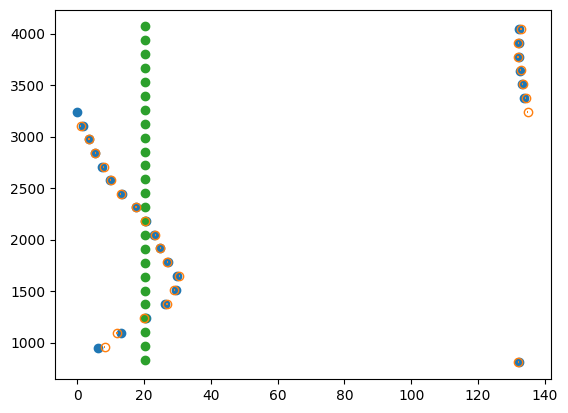

In [395]:
init_params = {
    "log_amp": jnp.log(10.0),
    "log_scale": jnp.log(4.0),
    "log_diag": jnp.log(1e-1),
    "delta_nu": delta_nu,
    "epsilon": 1.15,
    "log_a_he": jnp.log(1e-3),
    "log_b_he": jnp.log(2e-7),
    "log_tau_he": jnp.log(0.2/2/delta_nu),
    "phi_he": 0.0,
    "log_a_cz": jnp.log(2e6),
    "log_tau_cz": jnp.log(0.6/2/delta_nu),
    "phi_cz": 0.0,
}

nu_gp, nu_var = predict(init_params, n, nu, include_mean=False)
nu_sd = np.sqrt(nu_var)

nu_sm = smooth_component(init_params, n)
dnu_fit = glitch(init_params, nu_sm)

nu_init = nu_gp + nu_sm + dnu_fit

plt.plot(nu%delta_nu, nu, "o")
plt.errorbar(nu_init%delta_nu, nu_init, xerr=nu_sd, fmt="o", markerfacecolor="none")
plt.plot(nu_sm%delta_nu, nu_sm, "o")

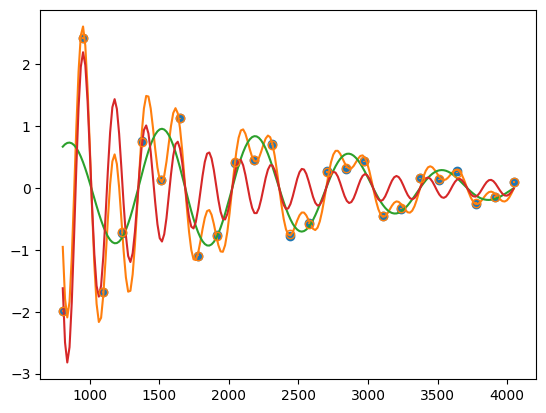

In [400]:
nu_pred = jnp.linspace(nu.min(), nu.max(), 201)
dnu_pred = glitch(init_params, nu_pred)

plt.plot(nu, nu-nu_fit+dnu_fit, "o")
plt.errorbar(nu, dnu_fit, yerr=nu_fit_sd, fmt="o", markerfacecolor="none")
plt.plot(nu_pred, dnu_pred, c="C1")

plt.plot(nu_pred, helium_glitch(init_params, nu_pred))
plt.plot(nu_pred, bcz_glitch(init_params, nu_pred))

<ErrorbarContainer object of 3 artists>

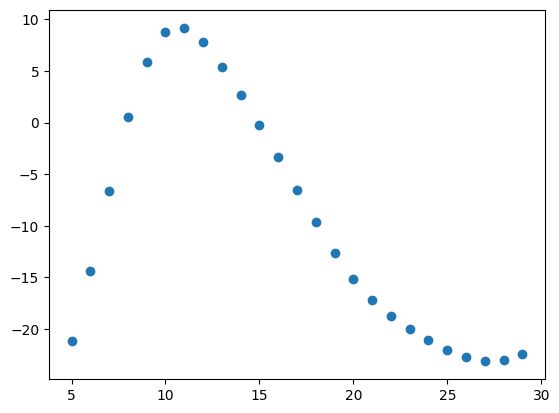

In [399]:
plt.errorbar(n, nu_gp, yerr=nu_sd, fmt="o")

In [401]:
solver = jaxopt.ScipyMinimize(method="BFGS", fun=loss)
sol = solver.run(init_params, n, nu)

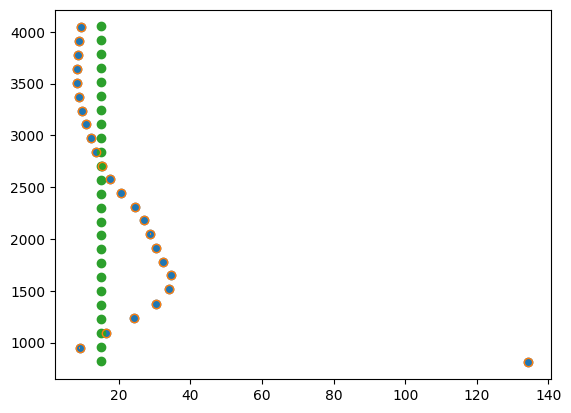

In [402]:
nu_gp, nu_var = predict(sol.params, n, nu, include_mean=False)
nu_sd = np.sqrt(nu_var)

nu_sm = smooth_component(sol.params, n)
dnu_fit = glitch(sol.params, nu_sm)

nu_init = nu_gp + nu_sm + dnu_fit

# nu_fit, nu_fit_var = predict(sol.params, n, nu)
# nu_fit_sd = np.sqrt(nu_fit_var)
# nu_sm = smooth_component(sol.params, n)

plt.plot(nu%sol.params["delta_nu"], nu, "o")
plt.errorbar(nu_fit%sol.params["delta_nu"], nu_fit, xerr=nu_fit_sd, fmt="o", markerfacecolor="none")
plt.plot(nu_sm%sol.params["delta_nu"], nu_sm, "o")

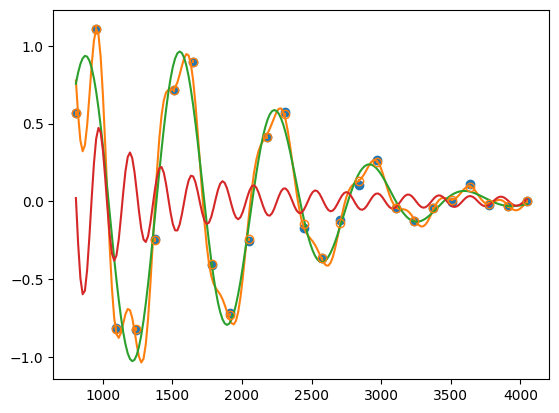

In [404]:
nu_pred = jnp.linspace(nu.min(), nu.max(), 201)
dnu_pred = glitch(sol.params, nu_pred)

dnu_fit = glitch(sol.params, nu_sm)

plt.plot(nu, nu-nu_fit+dnu_fit, "o")
plt.errorbar(nu, dnu_fit, yerr=nu_fit_sd, fmt="o", markerfacecolor="none")
plt.plot(nu_pred, dnu_pred, c="C1")

plt.plot(nu_pred, helium_glitch(sol.params, nu_pred))
plt.plot(nu_pred, bcz_glitch(sol.params, nu_pred))

Play around with the mask and you'll see how the residuals are smaller for smaller range of n. This is why polynomial is bad. It gets worse with more data.

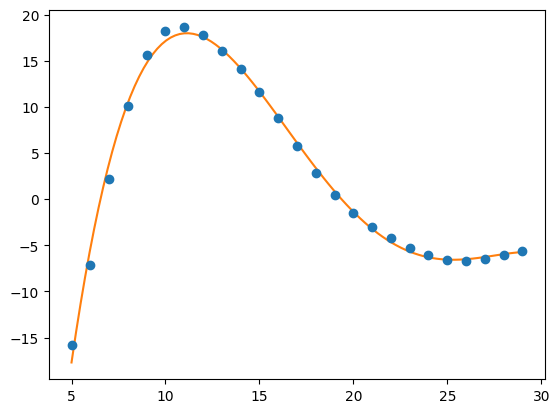

In [433]:
mask = (n > 4) & (n < 30)
coeff = np.polyfit(n[mask], nu_gp[mask], 4)

n_test = np.linspace(n.min(), n.max(), 101)
nu_test = np.polyval(coeff, n_test)

plt.errorbar(n[mask], nu_gp[mask], yerr=nu_sd[mask], fmt="o")
plt.plot(n_test, nu_test)

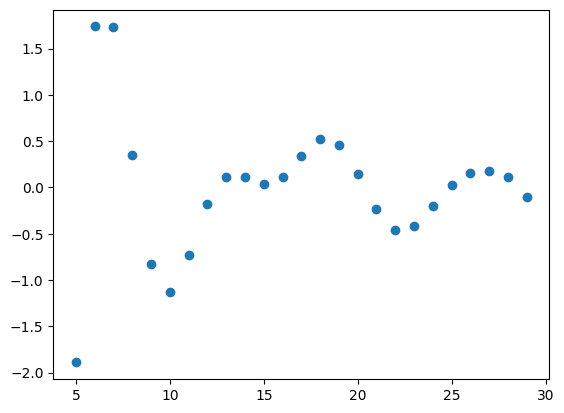

In [434]:
res = np.polyval(coeff, n[mask]) - nu_gp[mask]
plt.plot(n[mask], res, "o")

(array([1., 1., 2., 1., 2., 6., 4., 3., 2., 3.]),
 array([-0.0258856 , -0.02146125, -0.01703689, -0.01261254, -0.00818818,
        -0.00376383,  0.00066053,  0.00508488,  0.00950924,  0.01393359,
         0.01835795]),
 [<matplotlib.patches.Polygon at 0x152579160>])

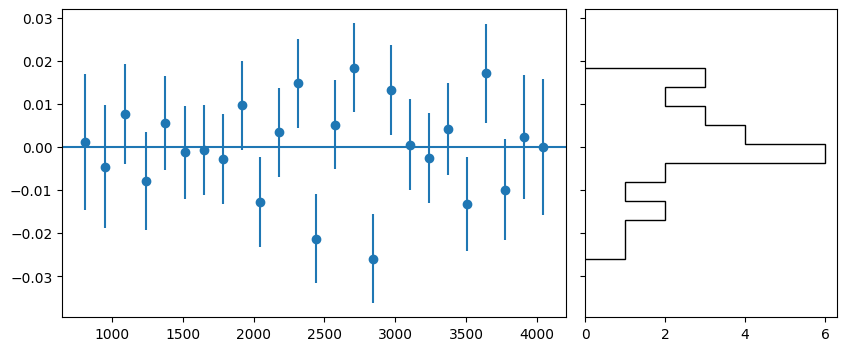

In [417]:
res = nu - nu_fit
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True,
                         gridspec_kw={"wspace": 0.05, "width_ratios": [2, 1]})

ax = axes[0]
ax.errorbar(nu, res, yerr=nu_fit_sd, fmt="o")
    
ax.axhline()
# ax.legend()

ax = axes[1]
ax.hist(res, orientation="horizontal", color="k", histtype="step")

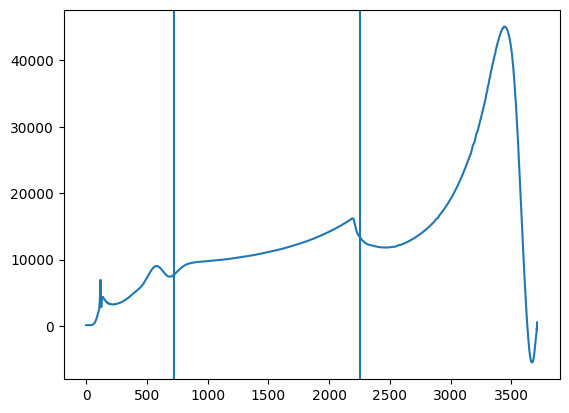

In [382]:
plt.plot(data.tau, differentiate(data.cs, data.tau))

plt.axvline(np.exp(sol.params["log_tau_he"])*1e6)
plt.axvline(np.exp(sol.params["log_tau_cz"])*1e6)

In [372]:
gamma_he = 1e6*np.exp(sol.params["log_a_he"])/sol.params["delta_nu"]
delta_he = 1e6*np.exp(0.5*sol.params["log_b_he"])*np.sqrt(2)/4/np.pi
tau_he = 1e6*np.exp(sol.params["log_tau_he"])

In [373]:
from scipy.stats import norm

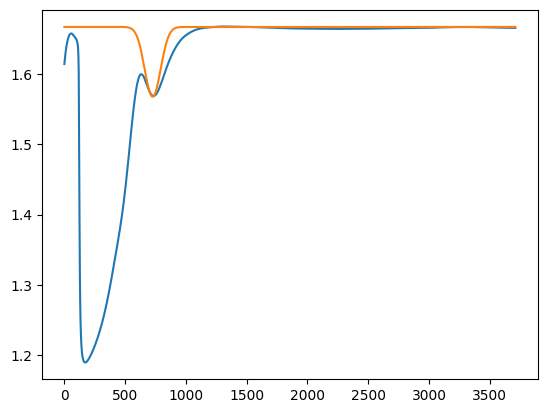

In [374]:
dgamma_gamma = - gamma_he * norm.pdf(data.tau, tau_he, delta_he)
# plt.plot(data.tau, data.Gamma_1*(1 - dgamma_gamma))
plt.plot(data.tau, data.Gamma_1)
plt.plot(data.tau, 5/3 + dgamma_gamma*data.Gamma_1)

In [330]:
hess = jax.hessian(loss)(sol.params, n, nu)

In [331]:
hess_flat, hess_def = tree_flatten(hess)

In [332]:
num_params = len(sol.params)

In [333]:
mean_flat, mean_def = tree_flatten(sol.params)
mean_array = np.array(mean_flat)

In [334]:
hess_array = jnp.reshape(jnp.array(hess_flat), (num_params, num_params))
cov_array = jnp.linalg.inv(hess_array)

In [335]:
rng = random.PRNGKey(0)

In [336]:
num_samples = 1000
keys = random.split(rng, num_samples)

samples = jax.vmap(
    random.multivariate_normal, in_axes=(0, None, None)
)(
    keys, mean_array, cov_array
)

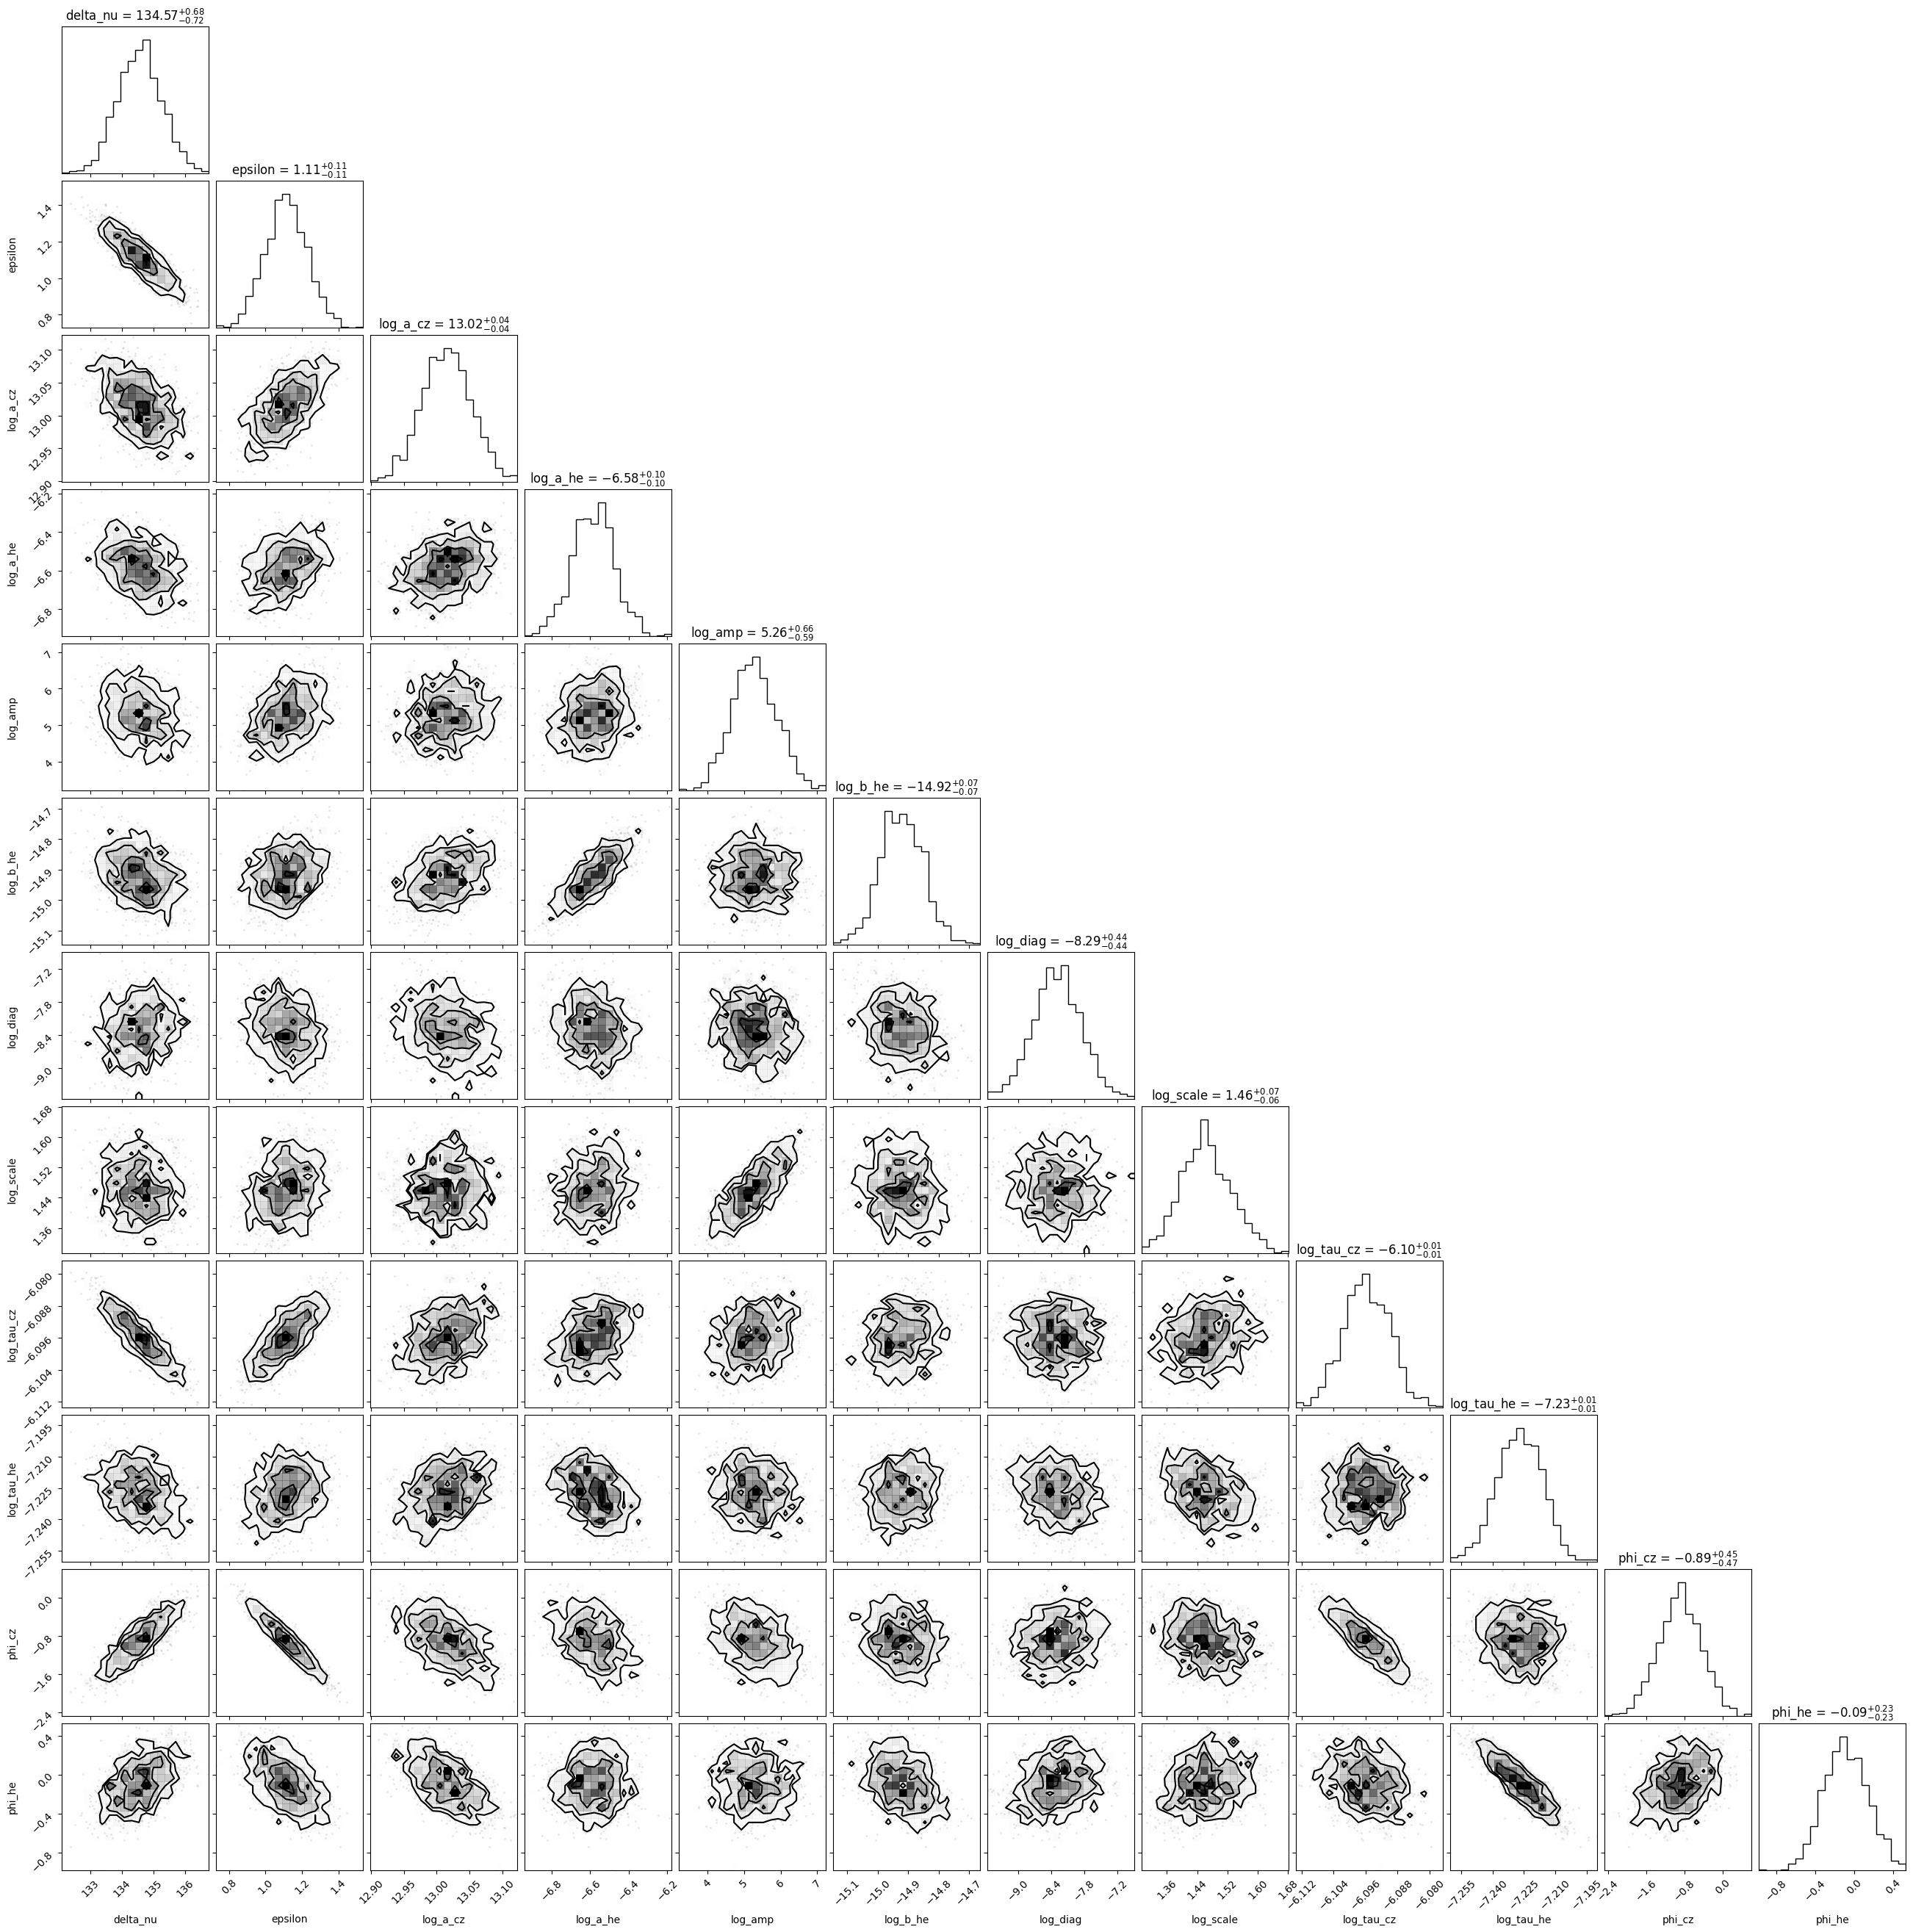

In [338]:
labels = list(sol.params.keys())
fig = corner(np.array(samples), labels=labels, show_titles=True)

In [344]:
1e6/2/sol.params["delta_nu"]

Array(3715.74142795, dtype=float64)

In [345]:
data.tau.max()

<xarray.DataArray 'tau' ()>
array(3710.25375824)